# Sampling the potential energy surface 

## Introduction 

This interactive notebook demonstrates how to utilize the Potential Energy Surface (PES) samplers algorithm of Qiskit Nature to generate the dissociation profile of a molecule. We use the Born-Oppenheimer Potential Energy Surface (BOPES) and demonstrate how to exploit bootstrapping and extrapolation to reduce the total number of function evaluations in computing the PES using the Variational Quantum Eigensolver (VQE). 


In [1]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# qiskit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP

# qiskit nature imports
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.algorithms.pes_samplers import BOPESSampler, Extrapolator

import warnings

warnings.simplefilter("ignore", np.RankWarning)

algorithm_globals.random_seed = 76

Here, we use the H2 molecule as a model system for testing.

In [2]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[stretch1],
)

# pass molecule to PSYCF driver
driver = ElectronicStructureMoleculeDriver(mol, driver_type=ElectronicStructureDriverType.PYSCF)

In [3]:
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.3])]


### Make a perturbation to the molecule along the absolute_stretching Degree of Freedom (DoF)

In [4]:
mol.perturbations = [0.2]
print(mol.geometry)

mol.perturbations = [0.6]
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.5])]
[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.8999999999999999])]


## Calculate bond dissociation profile using BOPES Sampler

Here, we pass the molecular information and the VQE to a built-in type called the BOPES Sampler. The BOPES Sampler allows the computation of the potential energy surface for a specified set of degrees of freedom/points of interest.

### First we compare no bootstrapping vs bootstrapping 

Bootstrapping the BOPES sampler involves utilizing the optimal variational parameters for a given degree of freedom, say r (ex. interatomic distance) as the initial point for VQE at a later degree of freedom, say r + $\epsilon$. By default, if bootstrapping is set to True, all previous optimal parameters are used as initial points for the next runs.

In [5]:
es_problem = ElectronicStructureProblem(driver)

qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)

me_gsc = GroundStateEigensolver(qubit_converter, solver)

In [6]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance1],
)

# pass molecule to PSYCF driver
driver = ElectronicStructureMoleculeDriver(mol, driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)


# Specify degree of freedom (points of interest)
points = np.linspace(0.20, 2, 30)
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition
conditions = {False: "no bootstrapping", True: "bootstrapping"}


for value, bootstrap in conditions.items():
    # define instance to sampler
    bs = BOPESSampler(gss=me_gsc, bootstrap=value, num_bootstrap=None, extrapolator=None)
    # execute
    res = bs.sample(es_problem, points)
    results_full[f"{bootstrap}"] = res.raw_results
    results[f"points_{bootstrap}"] = res.points
    results[f"energies_{bootstrap}"] = res.energies

## Compare to classical eigensolver


In [7]:
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(
    gss=me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None
)
# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

### Plot results

Text(0, 0.5, 'Energy')

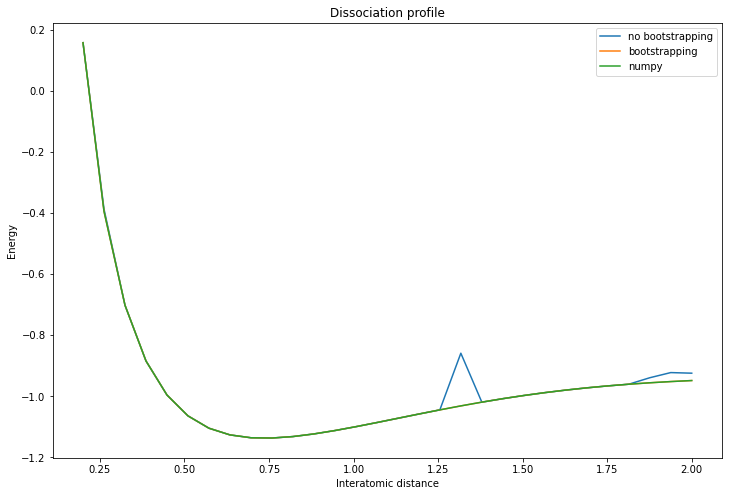

In [8]:
fig = plt.figure(figsize=(12, 8))

for value, bootstrap in conditions.items():
    plt.plot(results[f"points_{bootstrap}"], results[f"energies_{bootstrap}"], label=f"{bootstrap}")
plt.plot(results["points_np"], results["energies_np"], label="numpy")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

## Compare number of evaluations

In [9]:
for condition, result_full in results_full.items():
    print(condition)
    print("Total evaluations for " + condition + ":")
    sum = 0
    for key in result_full:
        if condition != "np":
            sum += result_full[key].raw_result.cost_function_evals
        else:
            sum = 0
    print(sum)

no bootstrapping
Total evaluations for no bootstrapping:
19979
bootstrapping
Total evaluations for bootstrapping:
2525
np
Total evaluations for np:
0


## Extrapolation 

Here, an extrapolator added that will try to fit each (param,point) set to some specified function and suggest an initial parameter set for the next point (degree of freedom). 

- Extrapolator is based on an external extrapolator that sets the 'window', that is, the number of previous points to use for extrapolation, while the internal extrapolator proceeds with the actual extrapolation.
- In practice, the user sets the window by specifying an integer value to num_bootstrap - which is also the number of previous points to use for bootstrapping. Additionally, the external extrapolator defines the space within how to extrapolate - here PCA, clustering and the standard window approach. 

In practice, if no extrapolator is defined and bootstrapping is True, then all previous points will be bootstrapped. If an extrapolator list is defined and no points are specified for bootstrapping, then the extrapolation will be done based on all previous points.

1. Window Extrapolator: An extrapolator which wraps another extrapolator, limiting the internal extrapolator's ground truth parameter set to a fixed window size
2. PCA Extrapolator: A wrapper extrapolator which reduces the points' dimensionality with PCA, performs extrapolation in the transformed pca space, and untransforms the results before returning.
3. Sieve Extrapolator: A wrapper extrapolator which performs an extrapolation, then clusters the extrapolated parameter values into two large and small clusters, and sets the small clusters' parameters to zero.
4. Polynomial Extrapolator: An extrapolator based on fitting each parameter to a polynomial function of a user-specified degree.
5. Differential Extrapolator: An extrapolator based on treating each param set as a point in space, and performing regression to predict the param set for the next point. A user-specified degree also adds derivatives to the values in the point vectors which serve as features in the training data for the linear regression.

### Here we test two different extrapolation techniques

In [10]:
# define different extrapolators
degree = 1
extrap_poly = Extrapolator.factory("poly", degree=degree)
extrap_diff = Extrapolator.factory("diff_model", degree=degree)
extrapolators = {"poly": extrap_poly, "diff_model": extrap_diff}

for key in extrapolators:
    extrap_internal = extrapolators[key]
    extrap = Extrapolator.factory("window", extrapolator=extrap_internal)
    # define extrapolator
    # BOPES sampler
    bs_extr = BOPESSampler(gss=me_gsc, bootstrap=True, num_bootstrap=None, extrapolator=extrap)
    # execute
    res = bs_extr.sample(es_problem, points)

    results_full[f"{key}"] = res.raw_results
    results[f"points_{key}"] = res.points
    results[f"energies_{key}"] = res.energies

### Plot results

poly
diff_model


Text(0, 0.5, 'Energy')

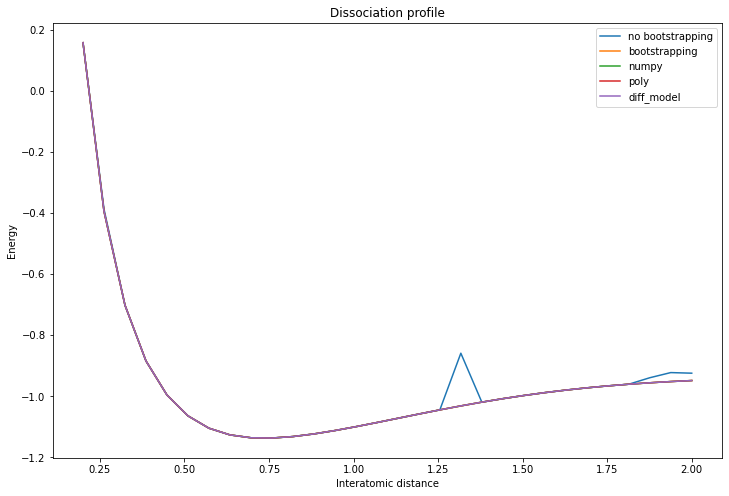

In [11]:
fig = plt.figure(figsize=(12, 8))

for value, bootstrap in conditions.items():
    plt.plot(results[f"points_{bootstrap}"], results[f"energies_{bootstrap}"], label=f"{bootstrap}")
plt.plot(results["points_np"], results["energies_np"], label="numpy")
for condition in extrapolators.keys():
    print(condition)
    plt.plot(results[f"points_{condition}"], results[f"energies_{condition}"], label=condition)
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

## Compare number of evaluations

In [12]:
for condition, result_full in results_full.items():
    print(condition)
    print("Total evaluations for " + condition + ":")
    sum = 0
    for key in results_full[condition].keys():
        if condition != "np":
            sum += result_full[key].raw_result.cost_function_evals
        else:
            sum = 0
    print(sum)

no bootstrapping
Total evaluations for no bootstrapping:
19979
bootstrapping
Total evaluations for bootstrapping:
2525
np
Total evaluations for np:
0
poly
Total evaluations for poly:
1068
diff_model
Total evaluations for diff_model:
2338


## Calculate bond dissociation profile using BOPES Sampler for excited states

In [16]:
from qiskit_nature.algorithms.excited_states_solvers import QEOM
from qiskit_nature.algorithms import NumPyEigensolverFactory, ExcitedStatesEigensolver
from qiskit_nature import settings
from typing import List, Union, Optional, Tuple, Dict
from qiskit.opflow import MatrixExpectation

settings.dict_aux_operators = True

### Find the excited states with QEOM

Takes about 1 min

In [19]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance1],
)

# Redefine the electronic structure problem
driver = ElectronicStructureMoleculeDriver(mol, driver_type=ElectronicStructureDriverType.PYSCF)
es_problem = ElectronicStructureProblem(driver)

# Redefine the solver (for the groundstate)
qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance, expectation=MatrixExpectation())
me_gsc = GroundStateEigensolver(qubit_converter, solver)

# Define the solver (for excited states)
qeom_solver = QEOM(me_gsc, "sd")

bs_qeom = BOPESSampler(gss=qeom_solver, bootstrap=True, num_bootstrap=None, extrapolator=None)
res_qeom = bs_qeom.sample(es_problem, points)

### Compare with the classical eigensolver

In [20]:
def filter_criterion(eigenstate, eigenvalue, aux_values):
    if isinstance(aux_values, Dict):
        pn = aux_values["ParticleNumber"][0]
        mg = aux_values["Magnetization"][0]
    if isinstance(aux_values, List):
        pn = aux_values[0][0]
        mg = aux_values[2][0]
    return np.isclose(pn, 2.0) and np.isclose(mg, 0.0)


new_numpy_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)
np_solver = ExcitedStatesEigensolver(qubit_converter, new_numpy_solver)

bs_np_exc = BOPESSampler(gss=np_solver, bootstrap=True, num_bootstrap=None, extrapolator=None)
res_np_exc = bs_np_exc.sample(es_problem, points)

### Plot the results

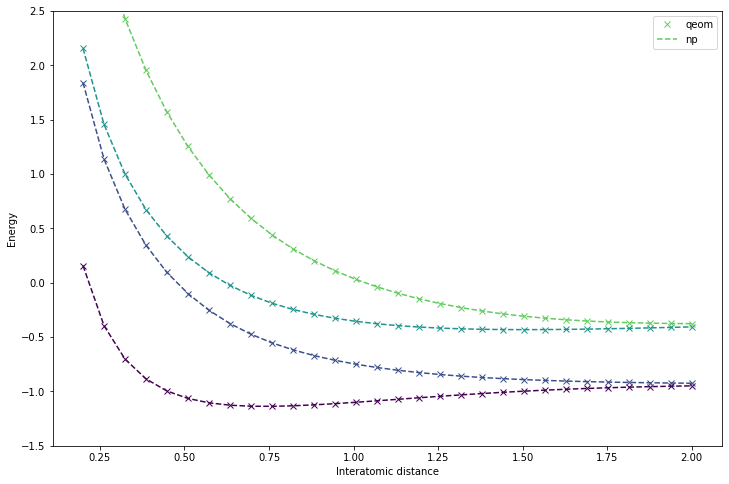

In [21]:
results_excited = {}
results_excited["points"] = points
results_excited["energies_np"] = np.array(res_np_exc.energies)
results_excited["energies_qeom"] = np.array(res_qeom.energies)

nb_excited_states = len(np.array(res_qeom.energies)[0])

cmap = plt.cm.get_cmap("viridis", len(points))
fig = plt.figure(figsize=(12, 8))

for k in range(nb_excited_states):
    (l1,) = plt.plot(
        results_excited["points"],
        results_excited["energies_qeom"][:, k],
        linestyle="",
        marker="x",
        color=cmap(k / nb_excited_states),
    )
    (l2,) = plt.plot(
        results_excited["points"],
        results_excited["energies_np"][:, k],
        linestyle="dashed",
        color=cmap(k / nb_excited_states),
    )
plt.legend([l1, l2], ["qeom", "np"])
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")
plt.ylim((-1.5, 2.5))
plt.show()

In [22]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright